In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import cxr_dataset as CXR
from tqdm import tqdm
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

d:\machineLearning\miniconda\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reading the data
data = pd.read_csv("clicks_val/CheXphoto-valid-v1.1/valid.csv")
data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXphoto-v1.1/valid/synthetic/digital/patient...,Male,73.0,Frontal,AP,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,CheXphoto-v1.1/valid/synthetic/digital/patient...,Male,70.0,Frontal,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,CheXphoto-v1.1/valid/synthetic/digital/patient...,Male,70.0,Lateral,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,CheXphoto-v1.1/valid/synthetic/digital/patient...,Male,85.0,Frontal,AP,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4,CheXphoto-v1.1/valid/synthetic/digital/patient...,Female,42.0,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# get shape of data
print('shape of data : ',data.shape)

shape of data :  (952, 19)


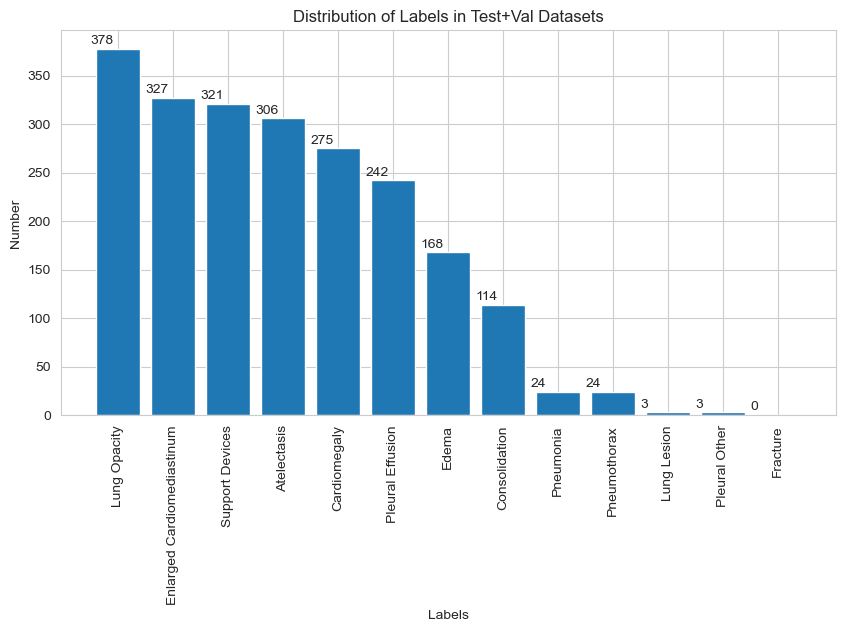

In [4]:
label = ['Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
data_disease = data[label]
disease_counts = data_disease.sum().sort_values(ascending=False)
fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.bar(np.arange(len(disease_counts))+0.5, disease_counts)
ax1.set_xticks(np.arange(len(disease_counts))+0.5)
ax1.set_xticklabels(disease_counts.index, rotation = 90)
plt.xlabel('Labels')
plt.ylabel('Number')
plt.title('Distribution of Labels in Test+Val Datasets')
for i, count in enumerate(disease_counts):
    plt.text(i, count+5, count, fontsize=10)
plt.show()

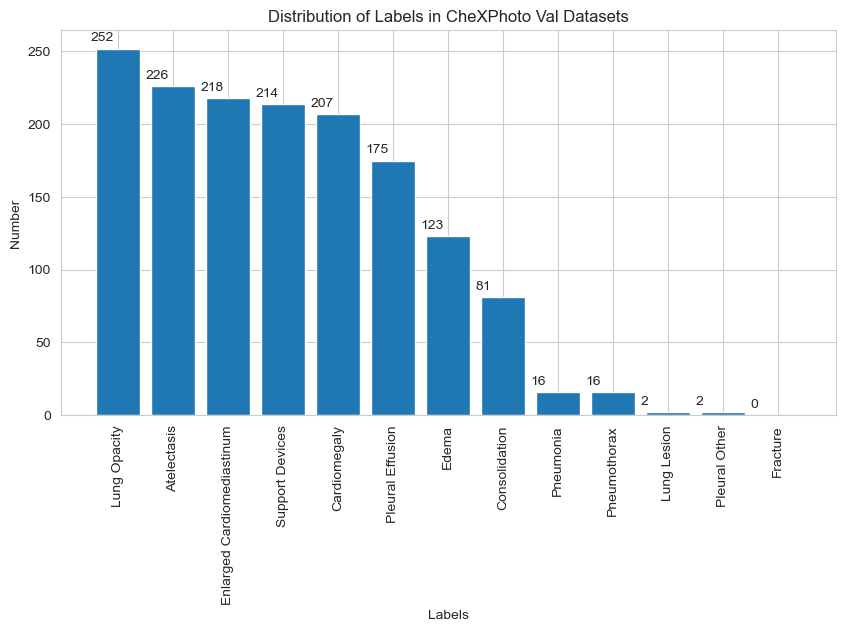

In [5]:
#not enough computing resources to process the train dataset
#use val dataset as training and test dataset as valid?
data_val = data[~data['Path'].str.contains('test')]
data_disease_val = data_val[label]
disease_counts_val = data_disease_val.sum().sort_values(ascending=False)
fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.bar(np.arange(len(disease_counts_val))+0.5, disease_counts_val)
ax1.set_xticks(np.arange(len(disease_counts_val))+0.5)
ax1.set_xticklabels(disease_counts_val.index, rotation = 90)
plt.xlabel('Labels')
plt.ylabel('Number')
plt.title('Distribution of Labels in CheXPhoto Val Datasets')
for i, count in enumerate(disease_counts_val):
    plt.text(i, count+5, count, fontsize=10)
plt.show()


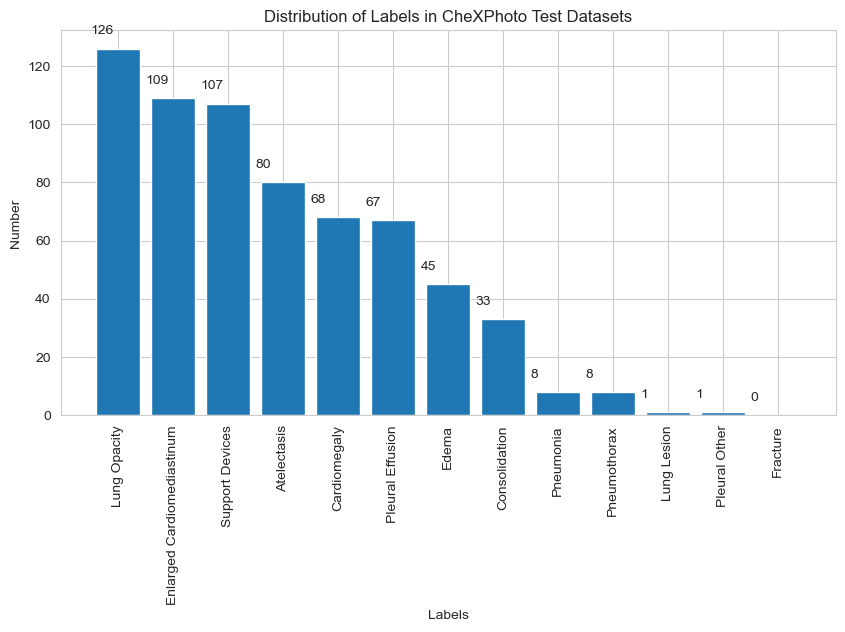

In [6]:
data_test = data[data['Path'].str.contains('test')]
data_disease_test = data_test[label]
disease_counts_test = data_disease_test.sum().sort_values(ascending=False)
fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.bar(np.arange(len(disease_counts_test))+0.5, disease_counts_test)
ax1.set_xticks(np.arange(len(disease_counts_test))+0.5)
ax1.set_xticklabels(disease_counts_test.index, rotation = 90)
plt.xlabel('Labels')
plt.ylabel('Number')
plt.title('Distribution of Labels in CheXPhoto Test Datasets')
for i, count in enumerate(disease_counts_test):
    plt.text(i, count+5, count, fontsize=10)
plt.show()

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            # because resize doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

# create train/val dataloaders
transformed_datasets = {}

#not enough computing resources to process the train dataset
'''
transformed_datasets['train'] = CXR.CXRDataset(
        path_to_images="imgdata/images-NIH-224/",
        fold='train',
        transform=data_transforms['train'])
'''
transformed_datasets['train'] = CXR.CPDataset(
        path_to_images="clicks_val/CheXphoto-valid-v1.1/",
        path_to_csv="clicks_val/CheXphoto-valid-v1.1/valid.csv",
        fold='train',
        transform=data_transforms['train'])

transformed_datasets['val'] = CXR.CPDataset(
        path_to_images="clicks_val/CheXphoto-valid-v1.1/",
        path_to_csv="clicks_val/CheXphoto-valid-v1.1/valid.csv",
        fold='val',
        transform=data_transforms['val'])

CheXphoto-v1.1/valid/synthetic/digital/patient64552/study1/view1_frontal.jpg
valid/synthetic/digital/patient64552/study1/view1_frontal.jpg
img_size = torch.Size([3, 224, 224])
label =
      Enlarged Cardiomediastinum
      Cardiomegaly
      Lung Opacity
      Edema
      Consolidation
      Pneumonia
      Atelectasis
      Pleural Effusion
img_id = valid/synthetic/digital/patient64552/study1/view1_frontal.jpg


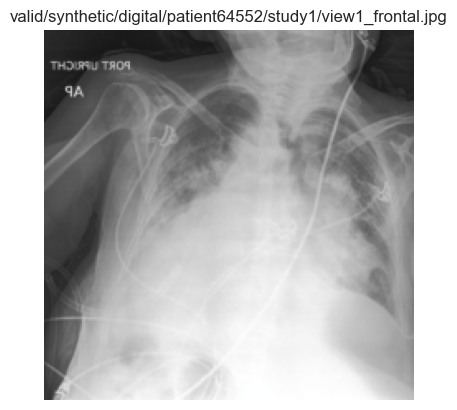

In [10]:
label = ['Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
inputs, labels, filename =transformed_datasets['train'][15]
print('img_size =', inputs.size())
print('label =')
for i in range(len(label)):
    if labels[i] == 1:
        print('     ',label[i])
print('img_id =', filename)
cxr=inputs.numpy().squeeze().transpose(1,2,0)    
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cxr = std * cxr + mean
cxr = np.clip(cxr, 0, 1)
# Display the image
plt.imshow(cxr)
plt.axis('off')
plt.title(filename)
plt.show()

CheXphoto-test-v1.0/valid/synthetic/photographic/patient64552/study1/view1_frontal.jpg
valid/synthetic/photographic/patient64552/study1/view1_frontal.jpg
img_size = torch.Size([3, 224, 224])
label =
      Enlarged Cardiomediastinum
      Cardiomegaly
      Lung Opacity
      Edema
      Consolidation
      Pneumonia
      Atelectasis
      Pleural Effusion
img_id = valid/synthetic/photographic/patient64552/study1/view1_frontal.jpg


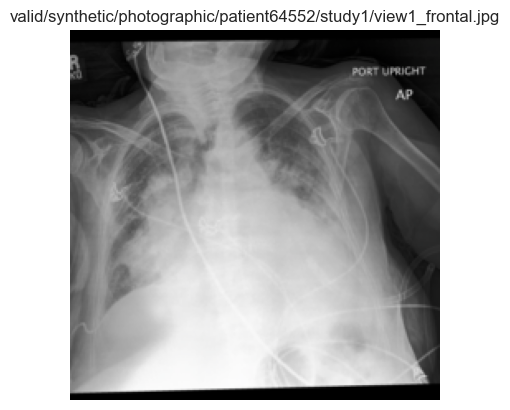

In [11]:
label = ['Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
inputs, labels, filename =transformed_datasets['val'][15]
print('img_size =', inputs.size())
print('label =')
for i in range(len(label)):
    if labels[i] == 1:
        print('     ',label[i])
print('img_id =', filename)
cxr=inputs.numpy().squeeze().transpose(1,2,0)    
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cxr = std * cxr + mean
cxr = np.clip(cxr, 0, 1)
# Display the image
plt.imshow(cxr)
plt.axis('off')
plt.title(filename)
plt.show()